In [36]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from tqdm import tqdm





import warnings
warnings.filterwarnings('ignore')

In [37]:
df = pd.read_csv('df.csv')

In [38]:
df.head()

,고객ID,최초거래년월,최종거래년월,거래활동기간,거래 연속성 비율,거래 밀도 지수,비활성화 기간 비율,총 거래 공백 개월수,월평균 거래금액,월평균 거래건수,최다가맹점업종명,업종다양성지수,신규유입고객,최다가맹점_광역시도,거래지역다양성지수,총거래금액,총거래건수
0,2002967708,202312,202312,1,100.0,5.0,0.0,0,210000.0,5.0,대형할인점,2,1,경상북도,2,210000,5.0
1,2004066711,202312,202312,1,100.0,2.5,0.0,0,40000.0,2.5,대형할인점,1,1,경기도,1,40000,2.5
2,2004166649,202312,202312,1,100.0,15.0,0.0,0,220000.0,15.0,기타잡화,6,1,경상북도,3,220000,15.0
3,2004326617,202312,202312,1,100.0,2.5,0.0,0,10000.0,2.5,편 의 점,1,1,경기도,1,10000,2.5
4,2004432929,202312,202312,1,100.0,5.0,0.0,0,460000.0,5.0,대형할인점,2,1,경기도,2,460000,5.0


## 승인 건수 점수

In [4]:
df['총거래건수'].describe()

count    915217.000000
mean        579.312313
std         779.780353
min           2.500000
25%          55.000000
50%         265.000000
75%         815.000000
max       17090.000000
Name: 총거래건수, dtype: float64

In [5]:
threshold_75 = df['총거래건수'].quantile(0.75)
filtered_df = df[df['총거래건수'] >= threshold_75]

filtered_df['총거래건수'].describe()

count    229077.000000
mean       1657.152606
std         852.968979
min         815.000000
25%        1057.500000
50%        1400.000000
75%        1982.500000
max       17090.000000
Name: 총거래건수, dtype: float64

In [39]:
df['승인건수점수'] = 0

df['승인건수점수'] = df['총거래건수'].apply(lambda x: 1 if 2 <= x <= 55 else 
                                              2 if 55 < x <= 265 else 
                                              3 if 265 < x <= 815 else 
                                              4 if 815 < x <= 1400 else 
                                              5 if 1400 < x else 0)

## 승인 금액 점수

In [40]:
df['월평균 거래금액'].describe()

count    9.152170e+05
mean     4.139387e+05
std      5.530044e+05
min      1.000000e+04
25%      1.031250e+05
50%      2.500000e+05
75%      5.216667e+05
max      4.967806e+07
Name: 월평균 거래금액, dtype: float64

In [41]:
t_75 = df['월평균 거래금액'].quantile(0.75)
filtered_df2 = df[df['월평균 거래금액'] >= t_75]

filtered_df2['월평균 거래금액'].describe()

count    2.288370e+05
mean     1.066250e+06
std      7.724001e+05
min      5.216667e+05
25%      6.477778e+05
50%      8.378571e+05
75%      1.198889e+06
max      4.967806e+07
Name: 월평균 거래금액, dtype: float64

In [42]:
df['승인금액점수'] = 0

df['승인금액점수'] = df['월평균 거래금액'].apply(lambda x: 1 if 10000 <= 110000 else 
                                              2 if 110000 < x <= 40000 else 
                                              3 if 40000 < x <= 250000 else 
                                              4 if 250000 < x <= 525000 else 
                                              5 if 525000 < x <= 1200000 else 
                                              6 if 1200000 < x  else 0)

## 승인점수

In [43]:
df['승인점수'] = df['승인건수점수'] + df['승인금액점수']

In [44]:
df

,고객ID,최초거래년월,최종거래년월,거래활동기간,거래 연속성 비율,거래 밀도 지수,비활성화 기간 비율,총 거래 공백 개월수,월평균 거래금액,월평균 거래건수,최다가맹점업종명,업종다양성지수,신규유입고객,최다가맹점_광역시도,거래지역다양성지수,총거래금액,총거래건수,승인건수점수,승인금액점수,승인점수
0,2002967708,202312,202312,1,100.00,5.00,0.00,0,210000.00,5.00,대형할인점,2,1,경상북도,2,210000,5.0,1,1,2
1,2004066711,202312,202312,1,100.00,2.50,0.00,0,40000.00,2.50,대형할인점,1,1,경기도,1,40000,2.5,1,1,2
2,2004166649,202312,202312,1,100.00,15.00,0.00,0,220000.00,15.00,기타잡화,6,1,경상북도,3,220000,15.0,1,1,2
3,2004326617,202312,202312,1,100.00,2.50,0.00,0,10000.00,2.50,편 의 점,1,1,경기도,1,10000,2.5,1,1,2
4,2004432929,202312,202312,1,100.00,5.00,0.00,0,460000.00,5.00,대형할인점,2,1,경기도,2,460000,5.0,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915212,9999918728,202105,202310,30,43.33,4.23,0.57,17,443076.92,4.23,대형할인점,6,1,대구광역시,1,5760000,55.0,1,1,2
915213,9999933174,202109,202212,16,43.75,9.29,0.56,9,611428.57,9.29,약 국,14,1,경기도,4,4280000,65.0,2,1,3
915214,9999972286,202101,202101,1,100.00,2.50,0.00,0,10000.00,2.50,편 의 점,1,0,대구광역시,1,10000,2.5,1,1,2
915215,9999981183,202101,202211,23,100.00,21.20,0.00,0,371304.35,21.20,일반한식,31,0,경상북도,6,8540000,487.5,3,1,4


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915217 entries, 0 to 915216
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   고객ID         915217 non-null  int64  
 1   최초거래년월       915217 non-null  int64  
 2   최종거래년월       915217 non-null  int64  
 3   거래활동기간       915217 non-null  int64  
 4   거래 연속성 비율    915217 non-null  float64
 5   거래 밀도 지수     915217 non-null  float64
 6   비활성화 기간 비율   915217 non-null  float64
 7   총 거래 공백 개월수  915217 non-null  int64  
 8   월평균 거래금액     915217 non-null  float64
 9   월평균 거래건수     915217 non-null  float64
 10  최다가맹점업종명     915217 non-null  object 
 11  업종다양성지수      915217 non-null  int64  
 12  신규유입고객       915217 non-null  int64  
 13  최다가맹점_광역시도   915217 non-null  object 
 14  거래지역다양성지수    915217 non-null  int64  
 15  총거래금액        915217 non-null  int64  
 16  총거래건수        915217 non-null  float64
 17  승인건수점수       915217 non-null  int64  
 18  승인금액점수       915217 non-

In [46]:
df.to_csv('df2.csv', index=False )

## 전처리

In [6]:
data = df[['거래활동기간','업종다양성지수','거래지역다양성지수',
             '총거래금액','총거래건수','거래 연속성 비율','거래 밀도 지수','승인점수','승인건수점수','승인금액점수','최다가맹점업종명']]

In [7]:
value_counts = data['최다가맹점업종명'].value_counts() 
data['업종빈도'] = data['최다가맹점업종명'].map(value_counts)

In [8]:
features1 = ['거래활동기간', '업종다양성지수', '거래지역다양성지수', '총거래금액', '총거래건수', '거래 연속성 비율', '거래 밀도 지수','승인점수', 
             '승인건수점수', '승인금액점수', '업종빈도']

In [9]:
df1 = data[features1].dropna()  
scaler = StandardScaler() 
df_scaled1 = scaler.fit_transform(df1) 
df_final = pd.DataFrame(df_scaled1, columns=df1.columns) 

## 주성분 수

In [10]:
df_final = df_final.apply(pd.to_numeric, errors='coerce')

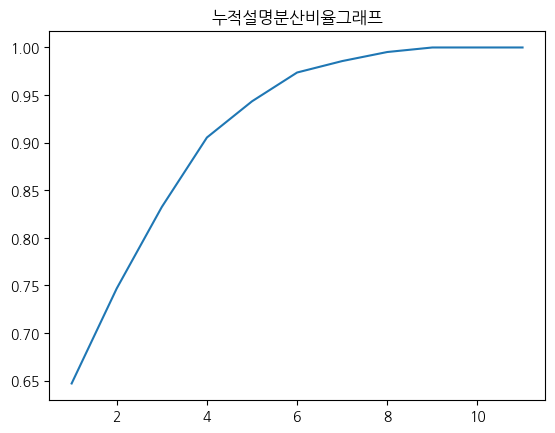

In [17]:
pca = PCA() 
pca.fit(df_final)

plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.title('누적설명분산비율그래프')
plt.show()

In [18]:
columns = ['거래활동기간', '업종다양성지수', '거래지역다양성지수', '총거래금액', '총거래건수', '거래 연속성 비율', '거래 밀도 지수','승인점수', 
             '승인건수점수', '승인금액점수', '업종빈도']
pca_components_df = pd.DataFrame(pca.components_, columns=columns)
pca_components_df.iloc[0].sort_values(ascending=False)

# 승인점수 > 승인건수점수 > 업종다양성지수 > 총거래건수 > 거래 밀도 지수 > 거래지역다양성지수 > 총거래 금액

승인점수         0.376196
승인건수점수       0.376196
업종다양성지수      0.371924
총거래건수        0.363541
거래 밀도 지수     0.342153
거래지역다양성지수    0.330169
총거래금액        0.309932
거래활동기간       0.240266
거래 연속성 비율    0.193019
업종빈도         0.171295
승인금액점수       0.000000
Name: 0, dtype: float64

## 필요 데이터만 담은 데이터셋

In [11]:
dataset = df_final[['승인점수','승인건수점수', '업종다양성지수', '총거래건수', '거래 밀도 지수', '거래지역다양성지수', '총거래금액']]

In [12]:
dataset

,승인점수,승인건수점수,업종다양성지수,총거래건수,거래 밀도 지수,거래지역다양성지수,총거래금액
0,-1.231716,-1.231716,-1.207081,-0.736506,-0.729912,-0.857603,-0.595073
1,-1.231716,-1.231716,-1.265241,-0.739712,-0.843029,-1.193987,-0.604321
2,-1.231716,-1.231716,-0.974441,-0.723682,-0.277444,-0.521219,-0.594529
3,-1.231716,-1.231716,-1.265241,-0.739712,-0.843029,-1.193987,-0.605953
4,-1.231716,-1.231716,-1.207081,-0.736506,-0.729912,-0.857603,-0.581473
...,...,...,...,...,...,...,...
915212,-1.231716,-1.231716,-0.974441,-0.672385,-0.764752,-1.193987,-0.293145
915213,-0.472519,-0.472519,-0.509161,-0.659561,-0.535803,-0.184835,-0.373659
915214,-1.231716,-1.231716,-1.265241,-0.739712,-0.843029,-1.193987,-0.605953
915215,0.286678,0.286678,0.479558,-0.117741,0.003086,0.487933,-0.141909


## 군집수 + 결과

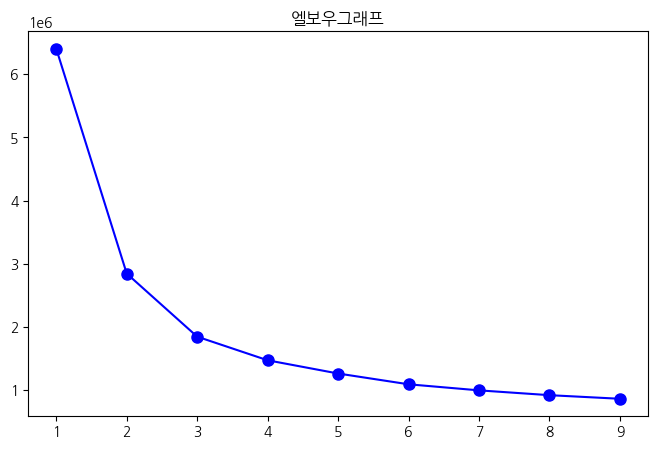

In [21]:
inertia = []
K = range(1, 10) 

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dataset)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-', markersize=8)
plt.title('엘보우그래프')
plt.show()

In [13]:
kmeans1 = KMeans(n_clusters=4, random_state=42)
df['Cluster1'] = kmeans1.fit_predict(dataset)

In [38]:
kmeans2 = KMeans(n_clusters=5, random_state=42)
df['Cluster2'] = kmeans2.fit_predict(dataset)

## 클러스터 결과

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915217 entries, 0 to 915216
Data columns (total 22 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   고객ID         915217 non-null  int64  
 1   최초거래년월       915217 non-null  int64  
 2   최종거래년월       915217 non-null  int64  
 3   거래활동기간       915217 non-null  int64  
 4   거래 연속성 비율    915217 non-null  float64
 5   거래 밀도 지수     915217 non-null  float64
 6   비활성화 기간 비율   915217 non-null  float64
 7   총 거래 공백 개월수  915217 non-null  int64  
 8   월평균 거래금액     915217 non-null  float64
 9   월평균 거래건수     915217 non-null  float64
 10  최다가맹점업종명     915217 non-null  object 
 11  업종다양성지수      915217 non-null  int64  
 12  신규유입고객       915217 non-null  int64  
 13  최다가맹점_광역시도   915217 non-null  object 
 14  거래지역다양성지수    915217 non-null  int64  
 15  총거래금액        915217 non-null  int64  
 16  총거래건수        915217 non-null  float64
 17  승인건수점수       915217 non-null  int64  
 18  승인금액점수       915217 non-

### 4군집

In [14]:
df_4 = df[['승인점수','승인건수점수', '업종다양성지수', '총거래건수', '거래 밀도 지수', '거래지역다양성지수', '총거래금액','최다가맹점업종명','Cluster1']]
df_4

,승인점수,승인건수점수,업종다양성지수,총거래건수,거래 밀도 지수,거래지역다양성지수,총거래금액,최다가맹점업종명,Cluster1
0,2,1,2,5.0,5.00,2,210000,대형할인점,0
1,2,1,1,2.5,2.50,1,40000,대형할인점,0
2,2,1,6,15.0,15.00,3,220000,기타잡화,0
3,2,1,1,2.5,2.50,1,10000,편 의 점,0
4,2,1,2,5.0,5.00,2,460000,대형할인점,0
...,...,...,...,...,...,...,...,...,...
915212,2,1,6,55.0,4.23,1,5760000,대형할인점,0
915213,3,2,14,65.0,9.29,4,4280000,약 국,0
915214,2,1,1,2.5,2.50,1,10000,편 의 점,0
915215,4,3,31,487.5,21.20,6,8540000,일반한식,1


In [15]:
numeric_columns = df_4.select_dtypes(include=['number']).columns

summary1 = df_4.groupby('Cluster1')[numeric_columns].mean()

In [16]:
summary1 = summary1.drop(columns=["Cluster1"])
summary1

,승인점수,승인건수점수,업종다양성지수,총거래건수,거래 밀도 지수,거래지역다양성지수,총거래금액
Cluster1,,,,,,,
0,2.453403,1.453403,8.083454,69.970257,7.053822,2.284159,1.744279e+06
1,3.927453,2.927453,26.963638,486.924031,19.708008,5.239181,9.118395e+06
2,5.988271,4.988271,59.293383,3008.850227,85.968673,9.903533,6.643178e+07
3,5.415268,4.415268,42.919603,1397.372784,42.397493,7.666686,2.422931e+07


In [17]:
top_categories = (
    df_4.groupby("Cluster1")["최다가맹점업종명"]
    .apply(lambda x: x.value_counts().head(5).index.tolist())
    .reset_index()
)

top_categories.columns = ["Cluster1", "최다업종명리스트"]

top_categories["최다업종명리스트"] = top_categories["최다업종명리스트"].apply(lambda x: ", ".join(x))
top_categories = top_categories.set_index("Cluster1")
top_categories

,최다업종명리스트
Cluster1,
0,"일반한식, 인터넷P/G, 슈퍼마켓, 기타 전문점, 서양음식"
1,"일반한식, 인터넷P/G, 슈퍼마켓, 편 의 점, 서양음식"
2,"일반한식, 인터넷P/G, 편 의 점, 서양음식, 슈퍼마켓"
3,"일반한식, 인터넷P/G, 편 의 점, 서양음식, 슈퍼마켓"


In [18]:
cluster4 = summary1.merge(top_categories, on='Cluster1')

In [19]:
cluster4

,승인점수,승인건수점수,업종다양성지수,총거래건수,거래 밀도 지수,거래지역다양성지수,총거래금액,최다업종명리스트
Cluster1,,,,,,,,
0,2.453403,1.453403,8.083454,69.970257,7.053822,2.284159,1.744279e+06,"일반한식, 인터넷P/G, 슈퍼마켓, 기타 전문점, 서양음식"
1,3.927453,2.927453,26.963638,486.924031,19.708008,5.239181,9.118395e+06,"일반한식, 인터넷P/G, 슈퍼마켓, 편 의 점, 서양음식"
2,5.988271,4.988271,59.293383,3008.850227,85.968673,9.903533,6.643178e+07,"일반한식, 인터넷P/G, 편 의 점, 서양음식, 슈퍼마켓"
3,5.415268,4.415268,42.919603,1397.372784,42.397493,7.666686,2.422931e+07,"일반한식, 인터넷P/G, 편 의 점, 서양음식, 슈퍼마켓"


### 5군집

In [69]:
df_5 = df[['승인점수','승인건수점수', '업종다양성지수', '총거래건수', '거래 밀도 지수', '거래지역다양성지수', '총거래금액','최다가맹점업종명','Cluster2']]

In [74]:
df_5

,승인점수,승인건수점수,업종다양성지수,총거래건수,거래 밀도 지수,거래지역다양성지수,총거래금액,최다가맹점업종명,Cluster2
0,2,1,2,5.0,5.00,2,210000,대형할인점,4
1,2,1,1,2.5,2.50,1,40000,대형할인점,4
2,2,1,6,15.0,15.00,3,220000,기타잡화,4
3,2,1,1,2.5,2.50,1,10000,편 의 점,4
4,2,1,2,5.0,5.00,2,460000,대형할인점,4
...,...,...,...,...,...,...,...,...,...
915212,2,1,6,55.0,4.23,1,5760000,대형할인점,4
915213,3,2,14,65.0,9.29,4,4280000,약 국,0
915214,2,1,1,2.5,2.50,1,10000,편 의 점,4
915215,4,3,31,487.5,21.20,6,8540000,일반한식,2


In [71]:
numeric_columns2 = df_5.select_dtypes(include=['number']).columns

summary2 = df_5.groupby('Cluster2')[numeric_columns2].mean()
summary2 = summary2.drop(columns=["Cluster2"])

In [75]:
summary2

,승인점수,승인건수점수,업종다양성지수,총거래건수,거래 밀도 지수,거래지역다양성지수,총거래금액
Cluster2,,,,,,,
0,3.008282,2.008282,12.979010,133.873480,9.265813,3.009293,3.142587e+06
1,5.988271,4.988271,59.293383,3008.850227,85.968673,9.903533,6.643178e+07
2,3.953200,2.953200,27.251913,496.408914,19.959999,5.269656,9.279719e+06
3,5.415268,4.415268,42.919603,1397.372784,42.397493,7.666686,2.422931e+07
4,2.000000,1.000000,4.249663,19.973061,5.342866,1.737598,6.346428e+05


In [78]:
top_categories2 = (
    df_5.groupby("Cluster2")["최다가맹점업종명"]
    .apply(lambda x: x.value_counts().head(5).index.tolist())
    .reset_index()
)

top_categories2.columns = ["Cluster2", "최다업종명리스트"]

top_categories2["최다업종명리스트"] = top_categories2["최다업종명리스트"].apply(lambda x: ", ".join(x))
top_categories2 = top_categories2.set_index("Cluster2")
top_categories2

,최다업종명리스트
Cluster2,
0,"일반한식, 인터넷P/G, 슈퍼마켓, 기타 전문점, 편 의 점"
1,"일반한식, 인터넷P/G, 편 의 점, 서양음식, 슈퍼마켓"
2,"일반한식, 인터넷P/G, 슈퍼마켓, 편 의 점, 서양음식"
3,"일반한식, 인터넷P/G, 편 의 점, 서양음식, 슈퍼마켓"
4,"일반한식, 슈퍼마켓, 인터넷P/G, 서양음식, 기타 전문점"


In [80]:
cluster5 = summary2.merge(top_categories2, on='Cluster2')

In [81]:
cluster5

,승인점수,승인건수점수,업종다양성지수,총거래건수,거래 밀도 지수,거래지역다양성지수,총거래금액,최다업종명리스트
Cluster2,,,,,,,,
0,3.008282,2.008282,12.979010,133.873480,9.265813,3.009293,3.142587e+06,"일반한식, 인터넷P/G, 슈퍼마켓, 기타 전문점, 편 의 점"
1,5.988271,4.988271,59.293383,3008.850227,85.968673,9.903533,6.643178e+07,"일반한식, 인터넷P/G, 편 의 점, 서양음식, 슈퍼마켓"
2,3.953200,2.953200,27.251913,496.408914,19.959999,5.269656,9.279719e+06,"일반한식, 인터넷P/G, 슈퍼마켓, 편 의 점, 서양음식"
3,5.415268,4.415268,42.919603,1397.372784,42.397493,7.666686,2.422931e+07,"일반한식, 인터넷P/G, 편 의 점, 서양음식, 슈퍼마켓"
4,2.000000,1.000000,4.249663,19.973061,5.342866,1.737598,6.346428e+05,"일반한식, 슈퍼마켓, 인터넷P/G, 서양음식, 기타 전문점"


## 시각화

In [83]:
matrix = df[['승인점수','승인건수점수', '업종다양성지수', '총거래건수', '거래 밀도 지수', '거래지역다양성지수', '총거래금액','최다가맹점업종명','Cluster1','Cluster2']]

In [84]:
numeric_matrix = matrix.select_dtypes(include=['number'])
correlation_matrix = numeric_matrix.corr()

correlation_matrix

,승인점수,승인건수점수,업종다양성지수,총거래건수,거래 밀도 지수,거래지역다양성지수,총거래금액,Cluster1,Cluster2
승인점수,1.000000,1.000000,0.895968,0.844689,0.785667,0.765548,0.659780,0.246844,-0.169800
승인건수점수,1.000000,1.000000,0.895968,0.844689,0.785667,0.765548,0.659780,0.246844,-0.169800
업종다양성지수,0.895968,0.895968,1.000000,0.831890,0.788146,0.841492,0.700005,0.243480,-0.119311
총거래건수,0.844689,0.844689,0.831890,1.000000,0.924822,0.700763,0.811106,0.458349,-0.040818
거래 밀도 지수,0.785667,0.785667,0.788146,0.924822,1.000000,0.667420,0.738905,0.402319,-0.055608
거래지역다양성지수,0.765548,0.765548,0.841492,0.700763,0.667420,1.000000,0.573188,0.211157,-0.094864
총거래금액,0.659780,0.659780,0.700005,0.811106,0.738905,0.573188,1.000000,0.371225,-0.071285
Cluster1,0.246844,0.246844,0.243480,0.458349,0.402319,0.211157,0.371225,1.000000,0.423569
Cluster2,-0.169800,-0.169800,-0.119311,-0.040818,-0.055608,-0.094864,-0.071285,0.423569,1.000000


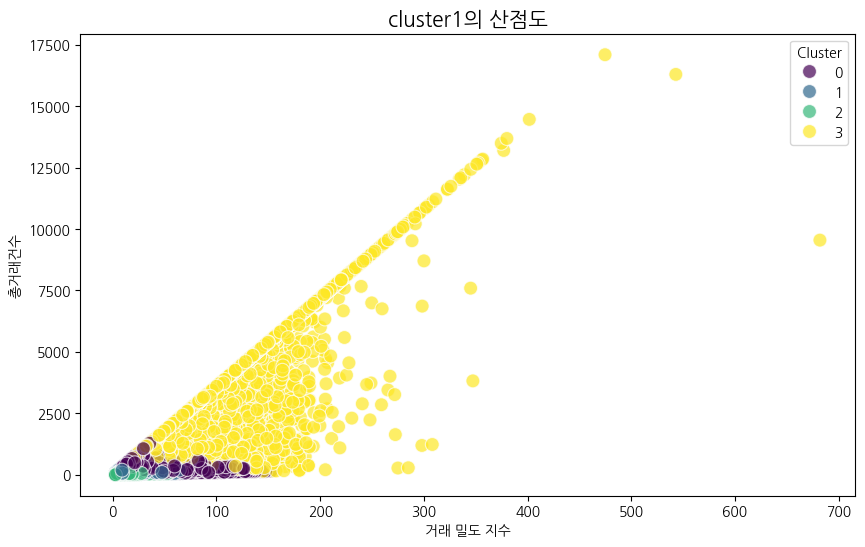

In [87]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=matrix, x = '거래 밀도 지수', y = '총거래건수', hue='Cluster1', palette='viridis', s=100, alpha=0.7)

plt.title('cluster1의 산점도', fontsize=15)
plt.legend(title='Cluster')

plt.show()

In [ ]:
scaled_matrix = scaler.fit_transform(numeric_matrix)

kmeans = KMeans(n_clusters=4, random_state=42)
matrix['Cluster_Label'] = kmeans.fit_predict(scaled_matrix)

centers = kmeans.cluster_centers_ 
centers_original_space = scaler.inverse_transform(centers)  

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=matrix, 
    x='거래 밀도 지수', 
    y='총거래건수', 
    hue='Cluster1',  
    palette='viridis', 
    s=100, 
    alpha=0.7
)

for i, center in enumerate(centers_original_space):
    plt.scatter(center[numeric_matrix.columns.get_loc('총거래금액')], 
                center[numeric_matrix.columns.get_loc('총거래건수')],   
                c='black', s=200, label=f'Center {i+1}', marker='X')

plt.title('Cluster1 산점도', fontsize=15)
plt.xlabel('거래 밀도 지수', fontsize=12)
plt.ylabel('총거래건수', fontsize=12)
plt.legend(title='Cluster', loc='upper right')
plt.show()

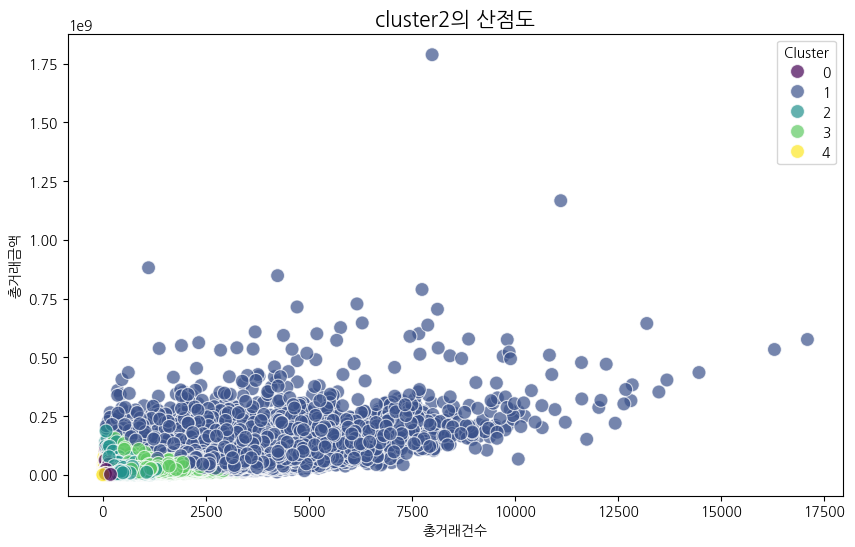

In [92]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=matrix,  x="총거래건수", y="총거래금액", hue='Cluster2', palette='viridis', s=100, alpha=0.7)

plt.title('cluster2의 산점도', fontsize=15)

plt.legend(title='Cluster')

plt.show()

## 평가

### DBI

In [90]:
dbi = davies_bouldin_score(scaled_matrix, matrix['Cluster1'])
print(f"Davies-Bouldin Index: {dbi:.2f}")

Davies-Bouldin Index: 0.64


In [93]:
dbi = davies_bouldin_score(scaled_matrix, matrix['Cluster2'])
print(f"Davies-Bouldin Index: {dbi:.2f}")

Davies-Bouldin Index: 0.72


# 4군집 해석

**군집 0**
승인점수/승인건수: 평균적으로 높은 승인점수와 승인건수를 기록하고 있음 (3.95, 2.95).\
업종 다양성 지수: 비교적 높은 업종 다양성 지수(27.25)로 다양한 업종과의 거래가 이루어짐.\
총거래건수/총거래금액: 거래건수는 496건으로 높은 편이며, 총거래금액도 매우 큼 (928만 이상).\
거래 밀도 지수/거래지역 다양성 지수: 거래 밀도(19.95)와 지역 다양성(5.27) 모두 적절히 분포되어 있음.\
최다 업종 명리스트: 다양한 업종(일반한식, 인터넷 P/G, 슈퍼마켓 등)에서 거래가 이루어지고 있음.
- 특징: 이 군집은 전반적으로 거래량과 업종 다양성이 높은 우량 군집으로 보이며, 다양한 업종과 활발히 거래를 하고 있는 사업체들로 구성되어 있음.

**군집 1**
승인점수/승인건수: 승인점수와 건수가 군집 0보다 낮음 (3.00, 2.00).\
업종 다양성 지수: 업종 다양성은 중간 수준 (12.98).\
총거래건수/총거래금액: 거래건수(133건)와 금액(314만)이 군집 0에 비해 낮음.\
거래 밀도 지수/거래지역 다양성 지수: 밀도(9.27)와 다양성(3.01)이 군집 0보다 낮은 수준.\
최다 업종 명리스트: 일반한식, 슈퍼마켓 등 소규모 업종 중심.
- 특징: 거래 규모와 업종 다양성이 군집 0에 비해 작고 특정 업종에 집중된 경향이 있는 군집으로, 중소형 사업체일 가능성이 있음.

**군집 2**
승인점수/승인건수: 매우 낮은 수준 (2.00, 1.00).\
업종 다양성 지수: 업종 다양성도 낮음 (4.25).\
총거래건수/총거래금액: 거래건수(19건)와 금액(63만)이 매우 적음.\
거래 밀도 지수/거래지역 다양성 지수: 밀도(5.34)와 지역 다양성(1.74) 모두 낮음.\
최다 업종 명리스트: 특정 업종(일반한식, 서양음식)에 집중됨.
- 특징: 거래 규모와 다양성이 매우 낮고, 지역적/업종적 한정된 소규모 사업체나 제한적인 거래 패턴을 가진 군집으로 보임.

**군집 3**
승인점수/승인건수: 가장 높은 점수와 건수를 기록 (5.52, 4.53).\
업종 다양성 지수: 매우 높은 다양성 지수 (46.16).\
총거래건수/총거래금액: 거래건수(1716건)와 금액(325만 이상)이 매우 많음.\
거래 밀도 지수/거래지역 다양성 지수: 밀도(51.02)와 다양성(8.10) 모두 높음.\
최다 업종 명리스트: 다양한 업종(인터넷 P/G, 편의점, 양육비 등)에서 활발한 거래가 이루어짐.
- 특징: 거래 규모, 업종 및 지역 다양성, 승인점수 등 모든 면에서 매우 우수한 군집으로, 대규모 사업체로 구성된 최우량 군집으로 보임.

**요약**
군집 0: 중대형 사업체, 거래량과 다양성 높은 우량 군집.\
군집 1: 소규모 사업체, 중간 수준의 거래와 업종 집중 경향.\
군집 2: 제한적인 거래와 업종 다양성을 가진 소규모 군집.\
군집 3: 대규모 사업체, 전방위적으로 거래가 활발한 최우량 군집.

**1. 군집 0: 중간 점수를 가진 안정적인 군집**\
**승인점수 (3.95)**와 **승인건수 (2.95)**는 높은 편이지만, 군집 3에 비해서는 다소 낮습니다.\
**거래 밀도 지수 (19.96)**는 비교적 높은 값으로, 특정 지역에서 안정적으로 거래가 이루어지고 있습니다.\
**거래지역 다양성 지수 (5.27)**도 평균 이상으로 다양한 지역에서 활동하고 있음을 나타냅니다.
- 해석:\
군집 0은 다양한 지역과 업종에서 안정적인 거래를 수행하는 중상위권 사업체로 보입니다. 점수는 비교적 높지만, 최상위군(군집 3)보다는 약간 낮은 수준입니다. 안정적인 관리와 추가적인 성장 전략이 필요할 수 있습니다.

**2. 군집 1: 점수가 낮은 제한적인 군집**\
**승인점수 (3.00)**와 **승인건수 (2.00)**는 군집 0에 비해 낮습니다.\
**거래 밀도 지수 (9.27)**와 **거래지역 다양성 지수 (3.01)**도 낮아, 거래량과 지역 확장이 제한적입니다.
- 해석:\
군집 1은 제한적인 거래와 낮은 점수를 가진 군집으로, 거래 신뢰도와 범위를 확장할 필요가 있는 중소형 사업체로 보입니다. 지원이나 신뢰도 개선을 위한 개입이 효과적일 수 있습니다.

**3. 군집 2: 점수가 가장 낮은 소규모 군집**\
**승인점수 (2.00)**와 **승인건수 (1.00)**는 가장 낮아, 거래 신뢰도가 매우 낮습니다.\
**거래 밀도 지수 (5.34)**와 **거래지역 다양성 지수 (1.74)**도 낮아, 지역적으로도 제한된 활동을 보입니다.
- 해석:
군집 2는 거래 신뢰도가 낮고 활동 범위가 제한된 군집으로, 소규모이거나 거래 규모가 미미한 신규 또는 소규모 사업체일 가능성이 높습니다. 특화된 지원 정책이나 성장 촉진 전략이 필요할 수 있습니다.

**4. 군집 3: 점수가 가장 높은 최우량 군집**\
**승인점수 (5.53)**와 **승인건수 (4.53)**가 가장 높아, 거래 신뢰도가 매우 높습니다.\
**거래 밀도 지수 (51.02)**와 거래지역 다양성 지수 (8.10) 역시 압도적으로 높은 값으로, 거래가 지역적으로도 매우 다양하고 밀집되어 있음을 보여줍니다.
- 해석:
군집 3은 점수 면에서 거래 신뢰도와 활동 범위가 매우 뛰어난 최우량 군집으로, 이미 성장세가 크고 안정적인 사업체들로 구성되어 있습니다. 이 군집은 핵심 고객으로 간주해 우대 정책이나 장기적인 파트너십 전략을 강화할 필요가 있습니다.

**점수 중심으로 요약**\
군집 0: 중간 점수와 안정적인 거래를 가진 중상위권 군집.\
군집 1: 제한적인 점수와 활동 범위를 가진 중하위권 군집.\
군집 2: 낮은 점수와 거래 규모를 가진 하위권 군집.\
군집 3: 점수가 가장 높고 활발히 거래를 수행하는 최우량 군집.

# 필요한 내용 저장(x)

In [29]:
df_4.to_csv("df_with_clusters.csv", index=False)
print("클러스터 할당 정보를 'df_with_clusters.csv'로 저장했습니다.")

cluster4.to_csv("cluster_centers.csv", index=True)
print("클러스터 중심 데이터를 'cluster_centers.csv'로 저장했습니다.")

클러스터 할당 정보를 'df_with_clusters.csv'로 저장했습니다.
클러스터 중심 데이터를 'cluster_centers.csv'로 저장했습니다.


In [30]:
print("Number of dataset columns:", len(dataset.columns))
print("Number of scaler means:", len(scaler.mean_))
print("Number of scaler stds:", len(scaler.scale_))

Number of dataset columns: 7
Number of scaler means: 11
Number of scaler stds: 11


In [34]:
scaling_info_array = np.array([scaler.mean_, scaler.scale_])
np.save("scaling_info.npy", scaling_info_array)
print("스케일링 기준 정보를 'scaling_info.npy'로 저장했습니다.")

스케일링 기준 정보를 'scaling_info.npy'로 저장했습니다.
Mean: [2.59149076e+01 2.27544998e+01 4.54947624e+00 1.11485462e+07
 5.79312313e+02 8.12678536e+01 2.11317884e+01 3.62239338e+00
 2.62239338e+00 1.00000000e+00 1.05424771e+05]
Std: [1.25585000e+01 1.71939597e+01 2.97279324e+00 1.83818583e+07
 7.79779927e+02 2.55407218e+01 2.21010060e+01 1.31718100e+00
 1.31718100e+00 1.00000000e+00 7.15061671e+04]
